In [33]:
#Graficamos la siguiente función
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

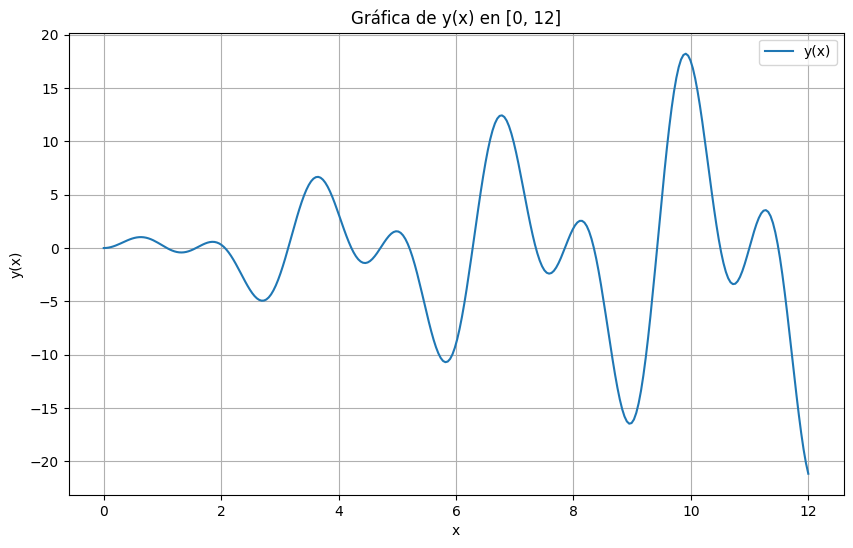

In [20]:
x = np.linspace(0, 12, 300)  # 300 puntos de 0 a 12
y = x * np.sin(4 * x) + 1.1 * x * np.sin(2 * x) 

# Graficar
fig = plt.figure(figsize=(10, 6))
plt.plot(x, y, label='y(x)')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Gráfica de y(x) en [0, 12]')
plt.grid(True)
plt.legend()
plt.show()

## Generamos las funciones para realizar el modelo basico 

In [ ]:
# Funcion para crear población binaria
def crearPoblacionBinaria(numero_de_individuos, longitud_cromosoma):
    poblacion = np.random.randint(0,2, size=(numero_de_individuos,longitud_cromosoma)) 
    print("Población inicial (binaria):")
    return poblacion

In [30]:
# Creación de la población
numero_de_individuos = 10
longitud_cromosoma = 8
poblacion = crearPoblacionBinaria(numero_de_individuos, longitud_cromosoma)

Población inicial (binaria):
[[1 0 1 0 0 0 0 0]
 [0 1 1 0 0 1 1 0]
 [0 0 0 1 1 1 1 1]
 [0 1 1 0 0 0 1 0]
 [1 0 1 1 0 1 0 0]
 [0 1 0 0 0 0 1 1]
 [1 1 0 1 1 0 0 1]
 [0 0 0 1 1 0 1 0]
 [0 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 0]]


In [22]:
# FUNCIÓN PARA CONVERTIR DE BINARIO A DECIMAL
def decodificarBinarioADecimal(poblacion, iMin, iMax):
    # P: población de individuos
    # Imin: Intervalo minimo 
    # Imax: Intervalo maximo
    [r, c] = poblacion.shape # r: numero de individuos, c: longitud de la representación binaria
    decimal = np.zeros(r)
    decimalRescalado = np.zeros(r)

    for i in range(r):
        for j in range(c):
            # Se transforma de binario a decimal entero
            decimal[i] = decimal[i] + poblacion[i, j] * 2 ** (c - j - 1)
            # Se reescala el valor decimal en el espacio de busqueda (0 a 2)
            decimalRescalado [i] = (iMax - iMin) * decimal[i] / (2 ** c - 1) + iMin
    return decimalRescalado

In [34]:
# Pueba decodficar poblacion
poblacion_decodificada = decodificarBinarioADecimal(poblacion, 0, 12)
print("Población decodificada (decimal):")
print(pd.DataFrame(poblacion_decodificada))

Población decodificada (decimal):
           0
0   7.529412
1   4.800000
2   1.458824
3   4.611765
4   8.470588
5   3.152941
6  10.211765
7   1.223529
8   0.941176
9   9.223529


In [23]:
def fitnessFuncion(poblacion, iMin, iMax):
    [r, c] = poblacion.shape
    x = decodificarBinarioADecimal(poblacion, iMin, iMax)
    fitness = x * np.sin(4 * x) + 1.1 * x * np.sin(2 * x) 
    return fitness

In [24]:
def crossover(poblacion, pc):
    [r, c] = poblacion.shape
    matrizAuxiliar = np.zeros((int(2 * pc), c)) # Matriz del tamaño doble a la original
    for i in range(int(pc)):
        
        seleccionPadres = np.random.randint(0, r, size=(1,2))

        padre1 = poblacion[seleccionPadres[0,0], : ]
        padre2 = poblacion[seleccionPadres[0,1], : ]

        # Seleccion del punto a cruzar
        seleccionCruce = np.random.randint(0,c)

        hijo1 = np.concatenate((padre1[0: seleccionCruce], padre2[seleccionCruce:]))
        hijo2 = np.concatenate((padre2[0: seleccionCruce], padre1[seleccionCruce:]))

        matrizAuxiliar[2 * i, :] = hijo1
        matrizAuxiliar[2 * i + 1, :] = hijo2
    return matrizAuxiliar

In [25]:
def mutacionAleatorio(poblacion, pm):
    [r, c] = poblacion.shape
    n = int(pm * c)

    for i in range(n):
        r1 = np.random.randint(0, r) # Numero aleatorio para seleccionar cual individuo va mutar
        r2 = np.random.randint(0, c) # Numero aleatorio para seleccionar el gen a mutar (0 o un 1)
        
        # Comparamos el gen del individiuo y lo cambiamos a su contrario 0 -> 1 ^ 1 -> 0
        if (poblacion[r1, r2] == 0):
            poblacion[r1, r2] = 1
        else:
            poblacion[r1, r2] = 0

    return poblacion


In [26]:
def seleccionPorToreno(poblacion, Imin, Imax, k):
    # k : Indice del tamaño del torneo
    [r, c] = poblacion.shape 
    aptitud = fitnessFuncion(poblacion, Imin, Imax).reshape(r, 1)
    matrizAuxiliar = np.concatenate([poblacion, aptitud], axis= 1)

    indicesTorneo = np.random.choice(r, size = k, replace = False)
    torneo = matrizAuxiliar[indicesTorneo, :]

    # Ordenamos por aptitud
    indices = np.argsort(torneo[:,-1])[::-1]   
    torneoOrdenado = torneo[indices] 

    mejorIndividuo = torneoOrdenado[0, 0:c]

    return mejorIndividuo

In [27]:
# FUNCIÓN QUE CREA UNA NUEVA POBLACIÓN MEDIANTE TORNEO
def nuevaPoblacionTorneo(poblacion, Imin, Imax, k):
    [r,c] = poblacion.shape
    pNew = np.zeros((r,c))

    # Se repite el torneo
    for i in range (r):
        pNew[i,:] = seleccionPorToreno(poblacion, Imin, Imax, k)
    return pNew

In [28]:
# Implementación del algoritmo genetico
print("Algoritmo genetico: Representación binarria 16bts\n")

#***************PARAMETROS DE INICIO*****************************
n = 100             # Cantidad de población
l = 16               # Cantidad de genes
generaciones = 20  # Numero de generaciones a realizar
ps = 0.6            # Porcentaje de selección no aleatoria
pc = n/2            # Pares a cruzar (cruza la mitad)
pm = 0.2            # Porcentaje de mutación (0.1 a 0.5 estandar)
Imin = 0            # Espacio de busqueda minima y de rescalar
Imax = 12            # Espacio de busqueda maxima y de rescalar
mejoresPorGeneracion = [] # Lista para almacenar el mejor valor de cada generación
k = 5               # Tamaño del torneo a formar

#*****************ALGORITMO GENETICO******************************
poblacion = crearPoblacionBinaria(n, l)
for i in range(generaciones):
    pCruzar = crossover(poblacion, pc)
    pMutada = mutacionAleatorio(pCruzar, pm)
    #pSelecc = seleccionRanking(pMutada, pm, Imin, Imax)
    #pSelecc = nuevaPoblacionTorneo(pMutada, Imin, Imax, k)
    pSelecc = nuevaPoblacionTorneo(pMutada, Imin, Imax, k)
    poblacion = pSelecc.copy()

#*****************RESULTADOS*************************************

pMejorDecimal = decodificarBinarioADecimal(pSelecc, Imin, Imax)
mejorIndividuo = pMejorDecimal[0]
print(f"El mejor individuo es: {poblacion[0,:]}")
print(f"En decimal es: {mejorIndividuo}")


Algoritmo genetico: Representación binarria 16bts

Población inicial (binaria):
[[1 0 0 ... 1 0 0]
 [0 0 1 ... 1 0 1]
 [1 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 1 1]]
El mejor individuo es: [1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
En decimal es: 9.909086747539483


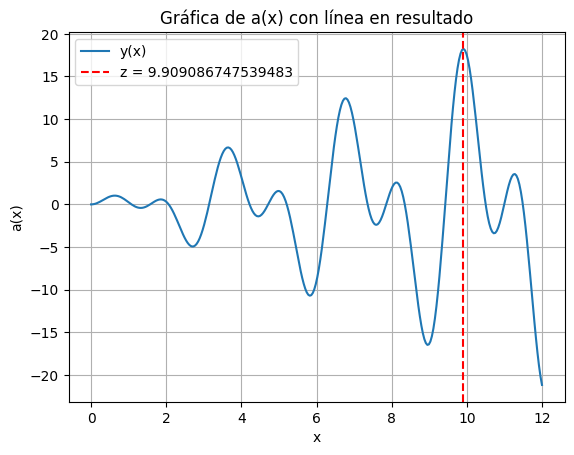

In [29]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 12, 300)  
y = x * np.sin(4 * x) + 1.1 * x * np.sin(2 * x) 
resultado = mejorIndividuo
# Graficar
plt.plot(x, y, label='y(x)')
# Inciertar un punto resultado
plt.axvline(x=resultado, color='r', linestyle='--', label=f'z = {resultado}')
plt.xlabel('x')
plt.ylabel('a(x)')
plt.title('Gráfica de a(x) con línea en resultado')
plt.grid(True)
plt.legend()
plt.show()